### Load Config

In [16]:
from yaml import load, Loader
from bunch import Bunch
Bunch.__str__ = Bunch.__repr__

stream = open("config.yaml", 'r')
config = Bunch(load(stream, Loader=Loader))

### Classification

#### Feature-based

In [20]:
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
import matplotlib.pyplot as plt
import seaborn as sns
import plotting_util as putil
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import get_scorer
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
import shap
import random

plt.rcParams['figure.facecolor'] = 'white'

SCORING = ['balanced_accuracy', 'roc_auc', 'f1_micro', 'average_precision', 'recall', 'precision']

PARAMETERS = {'n_estimators': [50, 100, 150], "max_features": ['sqrt', 'log2']}

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

SELECTED_FEATURES = [
    'gas',
    'brake',
    'SteerSpeed',
    'gas_vel',
    'brake_vel',
    'gas_acc',
    'gas_jerk',
    'acc',
    'acc_jerk',
    'lat_vel',
    'lane_position',
    'lane_crossing',
    'is_crossing_lane_left',
    'is_crossing_lane_right',
    'Ttc',
    'TtcOpp',
    'Thw',
    'Dhw',
    'SpeedDif',
    'speed_limit_exceeded'
]

#STATS = ['mean', 'std', 'min','max', 'q5', 'q95', 'range', 'iqrange', 'iqrange_5_95', 'sum', 'energy', 'skewness',
         #'kurtosis', 'peaks', 'rms', 'lineintegral', 'n_above_mean', 'n_below_mean', 'n_sign_changes', 'ptp']
STATS = ['mean', 'std', 'skewness', 'kurtosis', 'rms', 'q5', 'q95', 'min', 'max', 'sum']

SCENARIOS = ['highway', 'rural', 'town']

LOGO = LeaveOneGroupOut()

def collect_scores(scoring, y_true, y_pred):
    scores_dict = dict()
    for scorer in scoring:
        s = get_scorer(scorer)
        scores_dict[scorer] = s._score_func(y_true, y_pred)
    return scores_dict

top_n = 5
if config.plot_coef:
    fig, axes = putil.create_plot(len(config.window_sizes) * len(SIGNAL_COMBOS), len(SCENARIOS))
    putil.set_figure_size(fig, 40, 30)
    putil.set_fig_xlabel(fig, 'Coefficient', font_size=14)
    putil.set_fig_ylabel(fig, 'Top {} features'.format(top_n), font_size=14)
for i, window_size in enumerate(config.window_sizes):
    for j, combo in enumerate([SIGNAL_COMBOS[-1]]):
        signal_string = ''
        can_data_features = []
        for signal in combo:
            signal_string += '_' + signal
            can_data_features.append(pd.read_parquet('out/can_data_features_{}_windowsize_{}s_new.parquet'.format(signal, window_size)))
        can_data_features = pd.concat(can_data_features, axis=1)
        stat_columns_list = [[col for col in can_data_features.columns if col in [sig + '_' + s for s in STATS]] for sig in SELECTED_FEATURES]
        stat_columns = []
        for item in stat_columns_list:
            stat_columns += item
        can_data_features = can_data_features[stat_columns]
        can_data_features.loc[:, 'label'] = 0
        can_data_features.loc[(slice(None), 'above', slice(None), slice(None)), 'label'] = 1

        can_data_features.dropna(axis=1, inplace=True)

        # drop below BAC level for binary classification
        can_data_features = can_data_features.drop('below', level=1)

        for overlap_percentage in config.overlap_percentages:
            step = 1
            if overlap_percentage is not None:
                step = window_size - int(overlap_percentage * window_size)
            can_data_features_step = can_data_features[(can_data_features.groupby(['subject_id', 'subject_state', 'subject_scenario']).cumcount() % step) == 0]

            for k, scenario in enumerate(SCENARIOS):
                print('signals: {}, window size: {}s, step size: {}s ({}), scenario: {}'.format(
                    signal_string, window_size, step, overlap_percentage, scenario
                    ))

                can_data_features_bin = can_data_features_step.loc[:, :, scenario, :]

                groups = list(can_data_features.index.get_level_values('subject_id'))
                subject_ids = np.unique(groups)
                
                X = can_data_features.drop(columns='label').to_numpy(dtype=np.float64)
                
                y = can_data_features['label'].to_numpy()

                clf = None
                if config.classifier == 'log_regression':
                    clf = LogisticRegression(
                    penalty='l1', solver='saga', max_iter=1000, tol=1e-1, class_weight='balanced')
                elif config.classifier == 'random_forest':
                    clf = XGBClassifier(objective='binary:hinge', n_estimators=150, scale_pos_weight=np.bincount(y)[0] / float(np.bincount(y)[1]), use_label_encoder=False, n_jobs=1)
                else:
                    raise ValueError('Received unknown classifier string!')
                
                max_features = 15
                best_score = 0
                best_features = []
                for n_features in range(1, max_features+1):
                    sfs = SequentialFeatureSelector(clf, k_features=n_features, scoring='balanced_accuracy', cv=LOGO, n_jobs=len(subject_ids))
                    X_new = sfs.fit_transform(StandardScaler().fit_transform(X, y), y, groups=groups)
                    score = sfs.k_score_
                    if score > best_score:
                        best_score = score
                        best_features = can_data_features_bin.columns.to_numpy()[list(sfs.k_feature_idx_)]
                print(best_score)
                print(best_features)
                # vt = VarianceThreshold(threshold=0.2)
                # sfm = SelectFromModel(clf, threshold=-np.inf, max_features=50)

                pipeline = make_pipeline(StandardScaler(), clf)

                cv = cross_validate(estimator=pipeline, X=X_new, y=y, scoring=SCORING, return_estimator=True, verbose=0,
                        return_train_score=True, cv=LOGO, groups=groups, n_jobs=len(subject_ids))
                    
                if config.plot_coef and config.classifier == 'log_regression':
                    coefficients = []
                    for ind in range(len(subject_ids)):
                        est = cv['estimator'][ind]['logisticregression']
                        coefficients.append(est.coef_[0])
                    coefficients = pd.DataFrame(coefficients, columns=can_data_features_bin.columns.to_list()[:-1])
                    top_features = coefficients.mean(axis=0).abs().nlargest(top_n).index.to_list()
                    ax = axes[i*len(SIGNAL_COMBOS) + j][k]
                    if i*len(SIGNAL_COMBOS) + j == 0:
                        putil.set_ax_title(ax, scenario)
                    sns.swarmplot(ax=ax, data=coefficients.loc[:, top_features], orient='h', size=2)
                    putil.set_ax_grid_lines(ax, flag=True, style=':', axis='y', color='lightgrey')
                    putil.set_ax_visible_spines(ax, False, False, True, False)


                # for subject_id, est in zip(subject_ids, cv['estimator']):
                #     if not os.path.exists('out/results/subject_{}'.format(subject_id)):
                #         os.makedirs('out/results/subject_{}'.format(subject_id))
                #     RocCurveDisplay.from_estimator(est, X, y)
                #     plt.savefig('out/results/subject_{}/roc_curve_windowsize_{}{}_{}.png'.format(subject_id, window_size, signal_string, scenario))
                #     plt.close()

                # shap_values = np.zeros(can_data_features_bin.shape)
                # for ind in range(len(subject_ids)):
                #     feature_names = can_data_features_bin.columns.to_list()[:-1]
                #     explainer = shap.LinearExplainer(cv['estimator'][ind]['logisticregression'], X, feature_names=feature_names)
                #     shap_values += explainer.shap_values(X)
                
                # shap_values /= len(range(subject_ids))

                # shap_values = pd.DataFrame(shap_values)
                # shap_values.columns = feature_names

                # ind = random.choice(range(len(subject_ids)))
                # feature_names = can_data_features_bin.columns.to_list()[:-1]
                # explainer = shap.Explainer(cv['estimator'][ind]['logisticregression'], X, feature_names=feature_names)
                # shap_obj = explainer(X)
                # shap.plots.beeswarm(shap_obj)

                # shap_values.set_index(can_data_features_bin.index).to_parquet(
                #     'out/shap_values_windowsize_{}{}_{}.parquet'.format(window_size, signal_string, scenario), index=True
                # )

                # indices = cv['estimator'][0]['selectfrommodel'].get_support(indices=True)
                # print(can_data_features_bin.columns[indices])
                
                results = pd.DataFrame({k:v for k,v in cv.items() if k not in ['estimator']}).set_index(subject_ids)
                mean = results.mean(axis=0).rename('mean')
                std = results.std(axis=0).rename('stddev')
                results = results.append(mean)
                results = results.append(std)
                results.to_csv(
                        'out/results/{}_pred_results_windowsize_{}_step_size_{}s{}_{}.csv'.format(
                            config.classifier, window_size, step, signal_string, scenario
                            ), index=True, header=True
                        )

if config.plot_coef:
    plt.tight_layout()
    plt.savefig('out/results/{}_coef_top_{}.png'.format(config.classifier, top_n))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


signals: _driver_behavior_vehicle_behavior_navi_radar, window size: 120s, step size: 1s (None), scenario: highway
0.6649440379336479
['gas_q5' 'brake_sum' 'brake_skewness' 'brake_rms' 'SteerSpeed_std'
 'SteerSpeed_min' 'gas_vel_std' 'gas_vel_q95' 'gas_vel_kurtosis'
 'brake_vel_min' 'gas_acc_std' 'gas_acc_max' 'gas_acc_q5'
 'lane_crossing_max']
signals: _driver_behavior_vehicle_behavior_navi_radar, window size: 120s, step size: 1s (None), scenario: rural


#### Event-based

In [5]:
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
import matplotlib.pyplot as plt
import seaborn as sns
import plotting_util as putil
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import get_scorer
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
import shap
import random

SCORING = ['balanced_accuracy', 'roc_auc', 'f1_micro', 'average_precision', 'recall', 'precision']

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

#STATS = ['mean', 'std', 'min','max', 'q5', 'q95', 'range', 'iqrange', 'iqrange_5_95', 'sum', 'energy', 'skewness',
         #'kurtosis', 'peaks', 'rms', 'lineintegral', 'n_above_mean', 'n_below_mean', 'n_sign_changes', 'ptp']
STATS = ['mean', 'std', 'skewness', 'kurtosis', 'rms', 'q5', 'q95']

SCENARIOS = ['highway', 'rural', 'town']

LOGO = LeaveOneGroupOut()

can_data_events = []
for e in EVENTS:
    can_data_events.append(pd.read_parquet('out/can_data_{}_events.parquet'.format(e)))
can_data_events = pd.concat(can_data_events, axis=0)
stat_columns_list = [[col for col in can_data_events.columns if stat in col] for stat in STATS]
stat_columns = []
for item in stat_columns_list:
    stat_columns += item
can_data_events = can_data_events[['duration'] + stat_columns]

can_data_events.loc[:, 'label'] = 0
can_data_events.loc[(slice(None), 'above', slice(None), slice(None)), 'label'] = 1

can_data_events.dropna(axis=1, inplace=True)

# drop below BAC level for binary classification
can_data_events.drop('below', level=1, inplace=True)


for k, scenario in enumerate(SCENARIOS):
    print('scenario: {}'.format(scenario))

    can_data_events_bin = can_data_events.loc[:, :, scenario, :]

    groups = list(can_data_events_bin.index.get_level_values('subject_id'))
    subject_ids = np.unique(groups)
    
    X = can_data_events_bin.drop(columns='label').to_numpy(dtype=np.float64)
    
    y = can_data_events_bin['label'].to_numpy()

    clf = None
    if config.classifier == 'log_regression':
        clf = LogisticRegression(
        penalty='l1', solver='saga', max_iter=1000, tol=1e-1, class_weight='balanced')
    elif config.classifier == 'random_forest':
        clf = RandomForestClassifier(n_estimators=500, class_weight='balanced')
    else:
        raise ValueError('Received unknown classifier string!')
    
    #sfs = SequentialFeatureSelector(clf, n_features_to_select=5, scoring='roc_auc', n_jobs=len(subject_ids))
    #vt = VarianceThreshold(threshold=0.2)
    #sfm = SelectFromModel(clf, threshold=-np.inf, max_features=50)

    pipeline = make_pipeline(StandardScaler(), clf)

    cv = cross_validate(estimator=pipeline, X=X, y=y, scoring=SCORING, return_estimator=True, verbose=0,
            return_train_score=True, cv=LOGO, groups=groups, n_jobs=len(subject_ids))

    results = pd.DataFrame({k:v for k,v in cv.items() if k not in ['estimator']}).set_index(subject_ids)
    mean = results.mean(axis=0).rename('mean')
    std = results.std(axis=0).rename('stddev')
    results = results.append(mean)
    results = results.append(std)
    results.to_csv(
            'out/results/{}_pred_results_events_{}.csv'.format(
                config.classifier, scenario), index=True, header=True
            )

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


scenario: highway


/local/home/demircis/anaconda3/envs/DRIVE-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


scenario: rural
scenario: town


### Visualize Results

#### Feature-based

/tmp/ipykernel_34737/4284693279.py:114: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f444157bbb0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(scores)
/tmp/ipykernel_34737/4284693279.py:114: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f4441582700> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(scores)
/tmp/ipykernel_34737/4284693279.py:114: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f44495e3c40> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(scores)


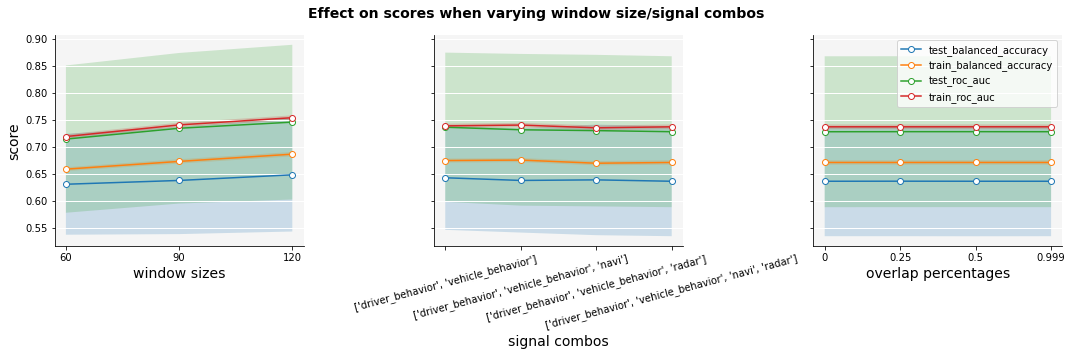

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

scores = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

fig, axes = putil.create_plot(nrows=1, ncols=3, sharey=True)
for ax in axes:
    putil.set_ax_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 15, 5)

# compare window sizes
avg_scores = []
avg_stddev = []
for window_size in config.window_sizes:
    avg_mean_scores = []
    stddev = []
    for combo in SIGNAL_COMBOS:
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}_step_size_1s{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', scores])
            stddev.append(results.loc['stddev', scores])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    stddev = np.array(stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(stddev)
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[0].plot(config.window_sizes, avg_scores[:, i], markerfacecolor='white', marker="o")
    axes[0].fill_between(config.window_sizes, y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
putil.set_ax_xticks(axes[0], config.window_sizes, config.window_sizes)
putil.set_ax_axis_labels(axes[0], x_label='window sizes', y_label='score')
putil.set_ax_bg_color(axes[0], 'whitesmoke')
putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")

# compare signal combos
avg_scores = []
avg_stddev = []
for combo in SIGNAL_COMBOS:
    avg_mean_scores = []
    mean_stddev = []
    for window_size in config.window_sizes:
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}_step_size_1s{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', scores])
            mean_stddev.append(results.loc['stddev', scores])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    mean_stddev = np.array(mean_stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(mean_stddev)
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[1].plot(range(len(avg_scores)), avg_scores[:, i], markerfacecolor='white', marker="o")
    axes[1].fill_between(range(len(avg_scores)), y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
putil.set_ax_xticks(axes[1], range(len(avg_scores)), SIGNAL_COMBOS, rotation=15)
putil.set_ax_axis_labels(axes[1], 'signal combos')
putil.set_ax_bg_color(axes[1], 'whitesmoke')
putil.set_ax_grid_lines(axes[1], True, axis="y", color="w")

# compare step sizes
avg_scores = []
avg_stddev = []
for overlap_percentage in config.overlap_percentages:
    avg_mean_scores = []
    mean_stddev = []
    for window_size in config.window_sizes:
        step = 1
        if overlap_percentage is not None:
            step = window_size - int(overlap_percentage * window_size)
        signal_string = ''
        for signal in SIGNAL_COMBOS[-1]:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}_step_size_{}s{}_{}.csv'.format(
                        config.classifier, window_size, step, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', scores])
            mean_stddev.append(results.loc['stddev', scores])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    mean_stddev = np.array(mean_stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(mean_stddev)
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[2].plot(range(len(avg_scores)), avg_scores[:, i], markerfacecolor='white', marker="o")
    axes[2].fill_between(range(len(avg_scores)), y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
xticks = config.overlap_percentages.copy()
xticks[-1] = '0.999'
putil.set_ax_xticks(axes[2], range(len(avg_scores)), xticks)
putil.set_ax_axis_labels(axes[2], 'overlap percentages')
putil.set_ax_bg_color(axes[2], 'whitesmoke')
putil.set_ax_grid_lines(axes[2], True, axis="y", color="w")

scores = ['test_balanced_accuracy', '_', 'train_balanced_accuracy', '_', 'test_roc_auc', '_', 'train_roc_auc']
plt.legend(scores)
putil.set_fig_title(fig, title='Effect on scores when varying window size/signal combos', font_size=14, font_weight='bold')
#putil.set_plot_title(title='Effect on scores when varying window size/signal combos', font_weight='bold', pad=15)
plt.tight_layout()
plt.savefig('out/results/{}_scores_varying_window_size_signal_combos_step_size.png'.format(config.classifier))

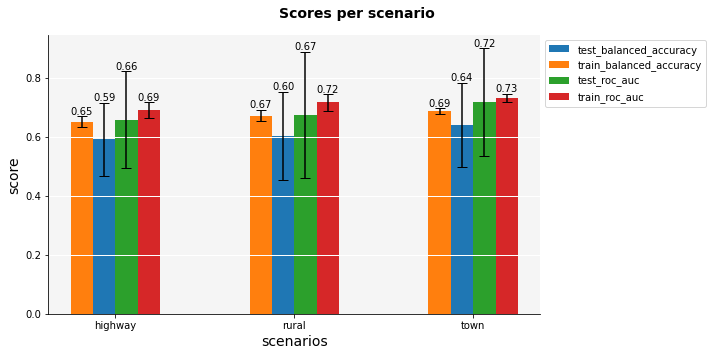

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

SCENARIOS = ['highway', 'rural', 'town']

scores = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

fig, axes = putil.create_plot(nrows=1, ncols=1, sharey=True)
for ax in axes:
    putil.set_ax_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 10, 5)

colors = ['C0', 'C1', 'C2', 'C3']
# compare scenarios
for i, scenario in enumerate(SCENARIOS):
    mean_scores = []
    mean_stddev = []
    for j, window_size in enumerate(config.window_sizes):
        signal_string = ''
        for signal in SIGNAL_COMBOS[-1]:
            signal_string += '_' + signal
        results = pd.read_csv('out/results/{}_pred_results_windowsize_{}{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
        mean_scores.append(results.loc['mean', scores])
        mean_stddev.append(results.loc['stddev', scores])
    mean_scores = np.array(mean_scores).mean(axis=0)
    mean_stddev = np.array(mean_stddev).mean(axis=0)
    width = 0.5
    frac = width/len(scores)
    for k in range(len(scores)):
        if k < len(scores) / 2:
            b = axes[0].bar(i+1 - (k+1)*frac, mean_scores[k], frac, yerr=mean_stddev[k], label=scores[k], color=colors[k], align='edge', capsize=5)
            axes[0].bar_label(b, fmt='%.2f')
        else:
            b = axes[0].bar(i+1 + (k-(len(scores)//2))*frac, mean_scores[k], frac, yerr=mean_stddev[k], label=scores[k], color=colors[k], align='edge', capsize=5)
            axes[0].bar_label(b, fmt='%.2f')
putil.set_ax_xticks(axes[0], range(1, len(SCENARIOS)+1), SCENARIOS)
putil.set_ax_axis_labels(axes[0], x_label='scenarios', y_label='score')
putil.set_ax_bg_color(axes[0], 'whitesmoke')
putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")
plt.legend(scores, bbox_to_anchor=(1.0, 1.0))
putil.set_fig_title(fig, title='Scores per scenario', font_size=14, font_weight='bold')
plt.tight_layout()
plt.savefig('out/results/{}_scores_per_scenario.png'.format(config.classifier))

#### Event-based

The handle <matplotlib.collections.PolyCollection object at 0x7fa7c0814a60> has a label of '_' which cannot be automatically added to the legend.
The handle <matplotlib.collections.PolyCollection object at 0x7fa7c0820220> has a label of '_' which cannot be automatically added to the legend.
The handle <matplotlib.collections.PolyCollection object at 0x7fa7c08208b0> has a label of '_' which cannot be automatically added to the legend.


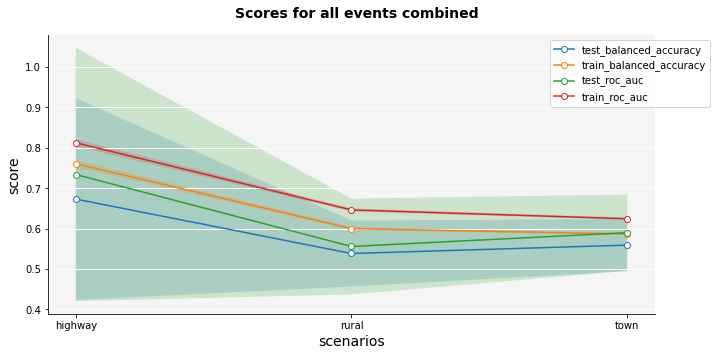

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

scores = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

SCENARIOS = ['highway', 'rural', 'town']

fig, axes = putil.create_plot(nrows=None, ncols=None, sharey=True)
for ax in axes:
    putil.set_ax_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 10, 5)

# compare window sizes
avg_scores = []
avg_stddev = []
for scenario in SCENARIOS:
    results = pd.read_csv('out/results/{}_pred_results_events_{}.csv'.format(
                config.classifier, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
    avg_scores.append(results.loc['mean', scores])
    avg_stddev.append(results.loc['stddev', scores])
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[0].plot(range(len(SCENARIOS)), avg_scores[:, i], markerfacecolor='white', marker="o")
    axes[0].fill_between(range(len(SCENARIOS)), y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
putil.set_ax_xticks(axes[0], range(len(SCENARIOS)), SCENARIOS)
putil.set_ax_axis_labels(axes[0], x_label='scenarios', y_label='score')
putil.set_ax_bg_color(axes[0], 'whitesmoke')
putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")

scores = ['test_balanced_accuracy', '_', 'train_balanced_accuracy', '_', 'test_roc_auc', '_', 'train_roc_auc']
plt.legend(scores, bbox_to_anchor=(1.1, 1.0))
putil.set_fig_title(fig, title='Scores for all events combined', font_size=14, font_weight='bold')
#putil.set_plot_title(title='Effect on scores when varying window size/signal combos', font_weight='bold', pad=15)
plt.tight_layout()
plt.savefig('out/results/{}_scores_events_combined.png'.format(config.classifier))